In [14]:
import pandas as pd
import numpy as np
import peptide
import re

In [194]:
df = pd.read_csv('data/data_table/data_sheet1.csv')
df = df.rename(columns={'Unnamed: 0': 'ranking'})
df = df[df.columns[:25]]

In [195]:
df.columns


Index(['ranking', 'each_original_data', 'ion1', 'loss1', 'loss_sign1',
       'charge1', 'mass1', 'ion2', 'loss2', 'loss_sign2', 'charge2', 'mass2',
       'addition_mass1', 'addition_mass2', 'ion_mass1', 'ion_mass2',
       'correct_mass1', 'correct_mass2', 'mass_difference1',
       'mass_difference2', 'm1+m2', '2m1+m2', 'm1+2m2', 'chosen_sum_from',
       'chosen_sum'],
      dtype='object')

In [196]:
df.head()

,ranking,each_original_data,ion1,loss1,loss_sign1,charge1,mass1,ion2,loss2,loss_sign2,...,ion_mass2,correct_mass1,correct_mass2,mass_difference1,mass_difference2,m1+m2,2m1+m2,m1+2m2,chosen_sum_from,chosen_sum
0,1,y7 (1+) @ 637.39 & b7 (1+) @ 690.36,y7,NaN,NaN,1+,637.39,b7,NaN,NaN,...,689.32451,637.305200,690.331760,0.084800,0.028240,1327.75,1965.14,2018.11,m1+m2,1327.75
1,2,y6 (1+) @ 580.39 & b8 (1+) @ 747.43,y6,NaN,NaN,1+,580.39,b8,NaN,NaN,...,746.34597,580.283740,747.353220,0.106260,0.076780,1327.82,1908.21,2075.25,m1+m2,1327.82
2,3,y5 (1+) @ 523.26 & b9 (1+) @ 804.37,y5,NaN,NaN,1+,523.26,b9,NaN,NaN,...,803.36743,523.262280,804.374680,-0.002280,-0.004680,1327.63,1850.89,2132.00,m1+m2,1327.63
3,4,y6 (1+) @ 580.37 & [b8-NH3] (1+) @ 730.35,y6,NaN,NaN,1+,580.37,b8,NH3,-,...,746.34597,580.283740,730.326671,0.086260,0.023329,1310.72,1891.09,2041.07,m1+m2,1310.72
4,5,[y4-NH3] (1+) @ 359.11 & b10 (1+) @ 951.13,y4,NH3,-,1+,359.11,b10,NaN,NaN,...,950.43584,359.167321,951.443090,-0.057321,-0.313090,1310.24,1669.35,2261.37,m1+m2,1310.24


In [94]:
def create_mass_conserve_line(row):
    ion1,ion2 = row['ion1'], row['ion2']
    loss1,loss2 = row['loss1'], row['loss2']
    if pd.isna(loss1):
        loss1 = ''
    if pd.isna(loss2):
        loss2 = ''
        
        
    #print((type(ion1) == str) and (ion1[0] == 'a' and ion1[:2] != 'ai'))
    #print((type(ion2) == str) and (ion2[0] == 'a' and ion2[:2] != 'ai')and (loss1 == '' and loss2 == ''))
    if (type(ion1) == str) and (ion1[0] == 'a' and ion1[:2] != 'ai') and (loss1 == '' and loss2 == ''):
        combined_loss = 'a'
    elif (type(ion2) == str) and (ion2[0] == 'a' and ion2[:2] != 'ai') and (loss1 == '' and loss2 == ''):
        combined_loss = 'a'
        
    elif loss1 != '' and loss2 != '':
        combined_loss = loss1 + ' + ' +loss2

    else:
        combined_loss = loss1 + loss2
    if combined_loss == '':
        combined_loss = 'Parent'
    return combined_loss


In [98]:
df['conserve_line'] = df.apply(create_mass_conserve_line, axis=1)

In [143]:
def peptie_arrange(length):
    result = []
    for i in range(1, length):
        result.append(f'b{i}y{length - i}')
    return result
        

In [179]:
rows = ['Parent','NH3','H2O', 'NH3 + H2O','H2O + NH3', 'a']
columns = peptie_arrange(14)
df['loss1_m'] = df['loss1'].fillna('')
df['loss2_m'] = df['loss2'].fillna('')

In [180]:
reuslt_df = pd.DataFrame(index=rows, columns=columns)

In [185]:
for index, each_row in df.iterrows():
    the_column = -1
    if (type(each_row['ion1']) == str and type(each_row['ion2']) == str):
        the_column = [each_row['ion1'], each_row['ion2']]
        the_column.sort()
        the_column = the_column[0] + the_column[1]
        the_column = the_column.replace('a', 'b')
    if (each_row['conserve_line'] in reuslt_df.index) and (the_column in reuslt_df.columns):
        print(each_row['conserve_line'])
        reuslt_df.at[each_row['conserve_line'], the_column] = each_row['ion1'] + each_row['loss1_m'] + each_row['ion2']+ each_row['loss2_m'] + ' \n ' +\
        each_row['chosen_sum_from'] + ' \n ' + str(round(each_row['mass_difference1'] + each_row['mass_difference2'], 2))
reuslt_df = reuslt_df.fillna('--')

Parent
Parent
Parent
NH3
NH3
NH3
NH3
NH3
a
NH3
H2O + NH3
Parent


In [186]:
reuslt_df

,b1y13,b2y12,b3y11,b4y10,b5y9,b6y8,b7y7,b8y6,b9y5,b10y4,b11y3,b12y2,b13y1
Parent,--,--,--,--,--,--,y7b7 \n m1+m2 \n 0.11,y6b8 \n m1+m2 \n 0.18,y5b9 \n m1+m2 \n -0.01,--,y3b11 \n m1+m2 \n -0.21,--,--
NH3,--,--,--,--,--,--,b7y7NH3 \n m1+m2 \n 0.87,y6NH3b8 \n m1+m2 \n 0.03,y5NH3b9 \n m1+m2 \n -0.02,y4NH3b10 \n m1+m2 \n -0.37,y3NH3b11 \n m1+m2 \n 0.31,--,--
H2O,--,--,--,--,--,--,--,--,--,--,--,--,--
NH3 + H2O,--,--,--,--,--,--,--,--,--,--,--,--,--
H2O + NH3,--,--,--,--,--,--,y7H2Ob7NH3 \n m1+m2 \n 0.18,--,--,--,--,--,--
a,--,--,--,--,--,--,--,y6a8 \n m1+m2 \n 0.4,--,--,--,--,--


In [163]:
df.columns

Index(['ranking', 'each_original_data', 'ion1', 'loss1', 'loss_sign1',
       'charge1', 'mass1', 'ion2', 'loss2', 'loss_sign2', 'charge2', 'mass2',
       'addition_mass1', 'addition_mass2', 'ion_mass1', 'ion_mass2',
       'correct_mass1', 'correct_mass2', 'mass_difference1',
       'mass_difference2', 'm1+m2', '2m1+m2', 'm1+2m2', 'chosen_sum_from',
       'chosen_sum', 'conserve_line'],
      dtype='object')

In [190]:
import pandas as pd
from html2image import Html2Image

# 1. Your original DataFrame and color dictionary
data = {
    'b12y1 | b2y1': ['(no loss,no loss) 0.31', '(no loss,NH3) -0.25', '(no loss,H2O)', '--'],
    'b3y10 | b4y9 | b5y8': ['--', '(NH3,no loss) -0.17', '--', '--'],
}
df = pd.DataFrame(data, index=['Parent', 'NH3', 'H2O', 'a'])

color_dict = {
    'NH3': 'blue',
    'H2O': 'red',
}

# 2. Create a copy of the DataFrame to modify its content
# It's good practice to work on a copy
df_display = df.copy().astype(str)

# 3. Iterate through the rows and inject HTML directly into the data
for index_name in df_display.index:
    if index_name in color_dict:
        color = color_dict[index_name]
        substring_to_color = index_name
        
        # Create the replacement HTML string
        replacement_html = f"<span style='color: {color}; font-weight: bold;'>{substring_to_color}</span>"
        
        # Modify the row in our display DataFrame
        # We use regex=False to ensure it treats the string literally
        df_display.loc[index_name] = df_display.loc[index_name].str.replace(
            substring_to_color, replacement_html, regex=False
        )

# 4. Now, apply simple, table-wide styles. No complex .apply() is needed.
styled_df = df_display.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center'
})

# 5. Export to HTML (with escape=False) and then to PNG
html_output = styled_df.to_html(escape=False)
with open("colored_substrings.html", "w") as f:
    f.write(html_output)

hti = Html2Image()
hti.screenshot(html_file='colored_substrings.html', save_as='colored_substrings.png')

22134 bytes written to file /Users/kevinmbp/Desktop/2D_spec_dict/colored_substrings.png


['/Users/kevinmbp/Desktop/2D_spec_dict/colored_substrings.png']

In [192]:
import pandas as pd
from html2image import Html2Image

# Your setup code remains the same
data = {
    'b12y1 | b2y1': ['(no loss,no loss) 0.31', '(no loss,NH3) -0.25', '(no loss,H2O)', '--'],
    'b3y10 | b4y9 | b5y8': ['--', '(NH3,no loss) -0.17', '--', '--'],
}
df = pd.DataFrame(data, index=['Parent', 'NH3', 'H2O', 'a'])
color_dict = {
    'NH3': 'blue',
    'H2O': 'red',
    'Parent': 'green'
}
df_display = df.copy().astype(str)
for index_name in df_display.index:
    if index_name in color_dict:
        color = color_dict[index_name]
        replacement_html = f"<span style='color: {color}; font-weight: bold;'>{index_name}</span>"
        df_display.loc[index_name] = df_display.loc[index_name].str.replace(
            index_name, replacement_html, regex=False
        )

# 💡 THE FIX: Rewrite the function to handle a Series
def color_index_series(index_labels_series):
    """
    Takes a Series of index labels and returns a Series of CSS styles.
    """
    # Use .map() to apply the logic to each label in the Series
    return index_labels_series.map(
        lambda label: f"color: {color_dict.get(label, 'black')}; font-weight: bold;"
    )

# Now, call the new function
styled_df = df_display.style.apply_index(color_index_series, axis="index") \
                          .set_properties(**{
                              'border': '1px solid black',
                              'text-align': 'center'
                          })

# Exporting remains the same
html_output = styled_df.to_html(escape=False)
with open("colored_table_and_index.html", "w") as f:
    f.write(html_output)

hti = Html2Image()
hti.screenshot(html_file='colored_table_and_index.html', save_as='colored_table_and_index.png')

22220 bytes written to file /Users/kevinmbp/Desktop/2D_spec_dict/colored_table_and_index.png


['/Users/kevinmbp/Desktop/2D_spec_dict/colored_table_and_index.png']

In [197]:
import pandas as pd
from html2image import Html2Image

# 1. Setup with a new color dictionary to show the substring logic
data = {
    'Fragment 1': ['(no loss,no loss) 0.31', '(no loss,NH3) -0.25', '(no loss,H2O)', '(loss, H2O+NH3)'],
    'Fragment 2': ['--', '(NH3,no loss) -0.17', '--', '--'],
}
df = pd.DataFrame(data, index=['Parent', 'NH3', 'H2O', 'H2O+NH3'])

# 'NH3' will get its color from the 'H2O+NH3' key
color_dict = {
    'H2O': 'red',
    'H2O+NH3': 'purple'
}

# 2. Modify the DataFrame content based on substring logic
df_display = df.copy().astype(str)
for index_name in df_display.index:
    # Loop through the color dictionary to find a key that contains our index_name
    for dict_key, color in color_dict.items():
        if index_name in dict_key:
            # Found a match, create the replacement HTML
            replacement_html = f"<span style='color: {color}; font-weight: bold;'>{index_name}</span>"
            
            # Modify the row in our display DataFrame
            df_display.loc[index_name] = df_display.loc[index_name].str.replace(
                index_name, replacement_html, regex=False
            )
            # Break the inner loop to use the first match found
            break

# 3. Modify the index styling function for substring logic
def color_index_series(index_labels_series):
    
    def get_color_for_label(label):
        # Iterate through the dictionary to find the first matching key
        for dict_key, color in color_dict.items():
            if label in dict_key:
                # Return the style for the matched key's color
                return f"color: {color}; font-weight: bold;"
        # Default style if no key contains the label
        return "color: black;"

    # Map the helper function to each label in the index Series
    return index_labels_series.map(get_color_for_label)

# 4. Chain the styling methods and export
styled_df = df_display.style.apply_index(color_index_series, axis="index") \
                          .set_properties(**{
                              'border': '1px solid black',
                              'text-align': 'center'
                          })

html_output = styled_df.to_html(escape=False)
with open("colored_substring_logic.html", "w") as f:
    f.write(html_output)

hti = Html2Image()
hti.screenshot(html_file='colored_substring_logic.html', save_as='colored_substring_logic.png')

25000 bytes written to file /Users/kevinmbp/Desktop/2D_spec_dict/colored_substring_logic.png


['/Users/kevinmbp/Desktop/2D_spec_dict/colored_substring_logic.png']

In [200]:
import pandas as pd
from html2image import Html2Image

# 1. Setup with a DataFrame and a color dict that matches indices exactly
data = {
    'Fragment 1': ['(loss, Parent)', '(no loss,NH3)', '(no loss,H2O)', '(H2O,NH3)'],
    'Fragment 2': ['--', '(NH3,no loss)', '--', '--'],
}
df = pd.DataFrame(data, index=['Parent', 'NH3', 'H2O', 'H2O+NH3'])

# The keys in this dictionary must now be an EXACT match for an index label
color_dict = {
    'H2O': 'red',
    'NH3': 'blue',
    'H2O+NH3': 'purple'
}

# 2. Prepare a list of all possible substrings to find (which are the indices)
substrings_to_find = df.index.tolist()

# Create a copy of the DataFrame to modify its content
df_display = df.copy().astype(str)

# 3. Modify the DataFrame content using the new index-first logic
for row_index, row_series in df.iterrows():
    # Get the color for the CURRENT ROW's index
    row_color = color_dict.get(row_index)

    # If this row's index doesn't have a color defined, we do nothing and move on
    if not row_color:
        continue

    # For the current row, find ALL substrings that are also indices
    # and color them with the ROW's color.
    current_row_data = df_display.loc[row_index]
    for substring in substrings_to_find:
        replacement_html = f"<span style='color: {row_color}; font-weight: bold;'>{substring}</span>"
        current_row_data = current_row_data.str.replace(
            substring, replacement_html, regex=False
        )
    df_display.loc[row_index] = current_row_data


# 4. The index styling function remains the same, as it already uses exact matches
def color_index_series(index_labels_series):
    return index_labels_series.map(
        lambda label: f"color: {color_dict.get(label, 'black')}; font-weight: bold;"
    )

# 5. Chain the styling methods and export
styled_df = df_display.style.apply_index(color_index_series, axis="index") \
                          .set_properties(**{
                              'border': '1px solid black',
                              'text-align': 'center'
                          })

html_output = styled_df.to_html(escape=False)
with open("final_colored_table.html", "w") as f:
    f.write(html_output)

hti = Html2Image()
hti.screenshot(html_file='final_colored_table.html', save_as='final_colored_table.png')

21758 bytes written to file /Users/kevinmbp/Desktop/2D_spec_dict/final_colored_table.png


['/Users/kevinmbp/Desktop/2D_spec_dict/final_colored_table.png']

In [203]:
import pandas as pd
from html2image import Html2Image
import re # We'll use regular expressions to find components

# 1. Setup - I've recreated your data from the screenshot
data = {
    'b1y9': ['--', '--', '--', '--', '--', '--', '--'], 'b2y8': ['(b2,y8)\n(1+, 1+)\n-0.15 (32)', '--', '--', '--', '(H2O,NH3)\n(1+, 1+)\n-0.15 (32)', '--', '2'],
    'b3y7': ['(b3,y7)\n(1+, 1+)\n-0.02 (3)', '(b3,NH3)\n(1+, 1+)\n-0.62 (13)', '--', '--', '--', '--', '2'],
    'Row_Count': [8, 8, 0, 1, 0, 0, 17]
}
df = pd.DataFrame(data, index=['Parent', 'NH3', 'H2O', 'NH3 + H2O', 'H2O + NH3', 'a', 'Col_Count'])

# The color dictionary still uses exact index matches
color_dict = {
    'NH3': 'blue',
    'H2O': 'red',
    'NH3 + H2O': 'green',
    'H2O + NH3': 'green' # Handle both permutations
}

# 2. Define a helper function to find all components in a string
# This list defines what we consider a "component"
known_components = df.index.tolist()

def get_components(label_string):
    """Uses regex to find all known components within a string."""
    # Create a regex pattern like '(NH3|H2O|Parent|...)'
    pattern = '|'.join(re.escape(c) for c in known_components if c.strip())
    return re.findall(pattern, label_string)

# 3. Modify the DataFrame using the new component-based logic
df_display = df.copy().astype(str).map(lambda x: x.replace('\n', '<br>')) # Handle newlines first

for row_index, row_series in df.iterrows():
    row_color = color_dict.get(row_index)
    if not row_color:
        continue
        
    # Get the fundamental components for THIS row
    components_to_color = get_components(row_index)
    
    # 💡 Sort by length (descending) to replace 'H2O+NH3' before 'H2O'
    components_to_color.sort(key=len, reverse=True)
    
    current_row_data = df_display.loc[row_index]
    for component in components_to_color:
        replacement_html = f"<span style='color: {row_color}; font-weight: bold;'>{component}</span>"
        current_row_data = current_row_data.str.replace(
            component, replacement_html, regex=False
        )
    df_display.loc[row_index] = current_row_data

# 4. The index styling function remains the same
def color_index_series(index_labels_series):
    return index_labels_series.map(
        lambda label: f"color: {color_dict.get(label, 'black')}; font-weight: bold;"
    )

# 5. Chain the styling methods and export
styled_df = df_display.style.apply_index(color_index_series, axis="index") \
                          .set_properties(**{
                              'border': '1px solid black',
                              'text-align': 'center'
                          })

html_output = styled_df.to_html(escape=False)
with open("final_complex_table.html", "w") as f:
    f.write(html_output)

from html2image import Html2Image
hti = Html2Image()
hti.screenshot(html_file='final_complex_table.html', save_as='final_complex_table.png')

31453 bytes written to file /Users/kevinmbp/Desktop/2D_spec_dict/final_complex_table.png


['/Users/kevinmbp/Desktop/2D_spec_dict/final_complex_table.png']

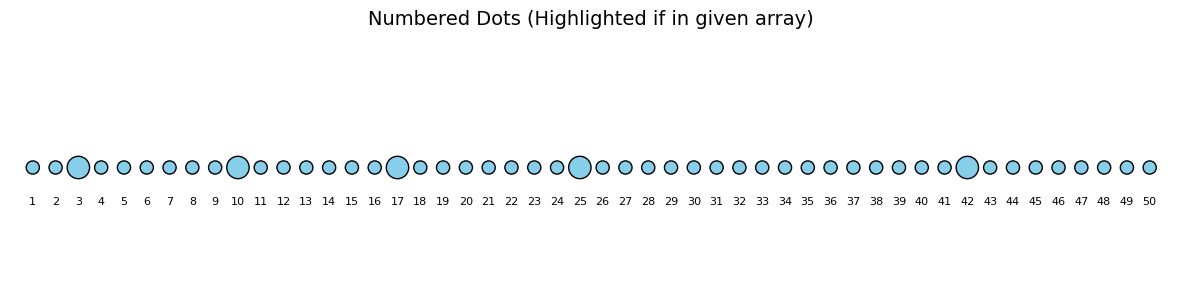

In [207]:
import matplotlib.pyplot as plt
import numpy as np

def plot_numbered_dots(highlight_array):
    """
    Generate a scatter plot of 50 dots labeled 1–50.
    Dots in highlight_array are drawn larger.
    """
    # Create 50 x positions spaced evenly
    x = np.arange(1, 51)
    y = np.zeros_like(x)  # place all dots on the same horizontal line

    # Create size array — larger for highlighted numbers
    sizes = np.where(np.isin(x, highlight_array), 260, 90)

    # Scatter plot
    plt.figure(figsize=(15, 3))
    plt.scatter(x, y, s=sizes, color='skyblue', edgecolor='black')

    # Add labels under each dot
    for i, val in enumerate(x):
        plt.text(x[i], -0.05, str(val), ha='center', va='top', fontsize=8)

    # Styling
    plt.axis('off')
    plt.title("Numbered Dots (Highlighted if in given array)", fontsize=14, pad=20)
    plt.ylim(-0.2, 0.2)
    plt.xlim(0, 51)

    plt.show()

# Example usage
highlight_array = [3, 10, 17, 25, 42]
plot_numbered_dots(highlight_array)

In [261]:
LETTER_ORDER = {ch: i for i, ch in enumerate("abcdefghijklmnopqrstuvwxyz")}

def first_letter(s):
    """Return the first alphabetic letter (lowercased) in s, or None if not found/NaN."""
    if pd.isna(s):
        return None
    m = re.search(r'[A-Za-z]', str(s))
    return m.group(0).lower() if m else None

def ion_key_by_first_letter(s):
    """Sort key based only on first alphabetic letter; unknowns go to the end."""
    lt = first_letter(s)
    return LETTER_ORDER.get(lt, 10_000)  # big number pushes unknowns to the end

def canonicalize_row_by_first_letter(row, paired_prefixes=("mass_difference", "charge")):
    """
    For a row with ion1/ion2 (e.g., 'y3', 'b7', 'bi(2-4)'):
    - Put the 'earlier' ion (by first letter) in 'ion_first', the other in 'ion_second'.
    - For each prefix in paired_prefixes, move the matching *1/*2 values into
      '<prefix>_first' and '<prefix>_second' in the same order as the ions.
    """
    ion1, ion2 = row["ion1"], row["ion2"]

    # decide if we need to swap based only on first letter
    swap = ion_key_by_first_letter(ion1) > ion_key_by_first_letter(ion2)

    out = {
        "ion_first":  ion2 if swap else ion1,
        "ion_second": ion1 if swap else ion2,
    }

    # remap any number of paired columns like mass_difference1/2, charge1/2, etc.
    for pref in paired_prefixes:
        v1 = row.get(f"{pref}1", np.nan)
        v2 = row.get(f"{pref}2", np.nan)
        out[f"{pref}_first"]  = v2 if swap else v1
        out[f"{pref}_second"] = v1 if swap else v2

    return pd.Series(out)



def create_mass_conserve_line(row):
    ion1,ion2 = row['ion_first'], row['ion_second']
    loss1,loss2 = row['loss_first'], row['loss_second']
    if pd.isna(loss1):
        loss1 = ''
    if pd.isna(loss2):
        loss2 = ''
        
        
    #print((type(ion1) == str) and (ion1[0] == 'a' and ion1[:2] != 'ai'))
    #print((type(ion2) == str) and (ion2[0] == 'a' and ion2[:2] != 'ai')and (loss1 == '' and loss2 == ''))
    if (type(ion1) == str) and (ion1[0] == 'a' and ion1[:2] != 'ai') and (loss1 == '' and loss2 == ''):
        combined_loss = 'a'
    elif (type(ion2) == str) and (ion2[0] == 'a' and ion2[:2] != 'ai') and (loss1 == '' and loss2 == ''):
        combined_loss = 'a'
    
    if (type(ion1) == str) and (ion1[0] == 'a' and ion1[:2] != 'ai'):
        loss1 = 'a' + '+' + loss1 if loss1 != '' else 'a'
        
    if (type(ion2) == str) and (ion2[0] == 'a' and ion2[:2] != 'ai'):
        loss2 = 'a' + '+' + loss2 if loss2 != '' else 'a'
        
    elif loss1 != '' and loss2 != '':
        combined_loss = loss1 + ' + ' +loss2

    else:
        combined_loss = loss1 + loss2
    if combined_loss == '':
        combined_loss = 'Parent'
    return combined_loss.replace(' ', '')


In [262]:
conserve_list = []
for i in range(1,8):
    df = pd.read_csv(f'data/data_table/data_sheet{i}.csv')
    df = df.rename(columns={'Unnamed: 0': 'ranking'})
    paired = ("mass_difference", "charge", 'loss')  # add more prefixes if you have them

    new_cols = df.apply(
        lambda r: canonicalize_row_by_first_letter(r, paired_prefixes=paired),
        axis=1
    )

    df = pd.concat([df, new_cols], axis=1)
    df['conserve_line'] = df.apply(create_mass_conserve_line, axis=1)
    conserve_list.append(df.groupby('conserve_line').size().sort_values(ascending=False))

In [263]:
conserve_list[6]

conserve_line
Parent           24
NH3              11
H3PO4             5
H2O               2
H3PO4-H2O         2
H2O+HCOOH-H2O     1
H3PO4+NH3         1
HCOOH-H2O         1
NH3+H2O           1
NH3+NH3           1
a+NH3             1
dtype: int64

In [264]:
merged_sum = pd.concat(conserve_list, axis=1).sum(axis=1)

In [265]:
merged_sum.sort_values(ascending=False)

conserve_line
Parent                153.0
NH3                    76.0
a                      14.0
a+NH3                  11.0
H2O-NH3                11.0
H2O                    11.0
NH3+NH3                10.0
HCOOH                   5.0
H3PO4                   5.0
HCOH-H2O                4.0
2(H2O)                  3.0
a+NH3+NH3               3.0
H2O+H2O                 2.0
HN=C=NH-2(H2O)          2.0
H3PO4-H2O               2.0
NH3-H2O                 2.0
NH3+H2O                 2.0
CH3NH2-NH3              2.0
CH3-NH2                 2.0
H2O-NH3+CHONH2          1.0
CH3SH-CO                1.0
CH3CH2SCH3              1.0
CH3-NH-CH3              1.0
H2O-NH3+NH3             1.0
HCOH-H2O+NH3            1.0
a+H2O+NH3               1.0
CH3NHCH3                1.0
a+2(H2O)                1.0
H3C-N=CH2-NH3           1.0
HCONH2                  1.0
H2O+HCOOH-H2O           1.0
H3PO4+NH3               1.0
CH3NHCH3-H2O            1.0
a+NH3-H2O+CH3NH2        1.0
H2O-2(NH3)              1.0
2(NH3)

In [270]:
conserve_list[6]

conserve_line
Parent           24
NH3              11
H3PO4             5
H2O               2
H3PO4-H2O         2
H2O+HCOOH-H2O     1
H3PO4+NH3         1
HCOOH-H2O         1
NH3+H2O           1
NH3+NH3           1
a+NH3             1
dtype: int64

# Top Pairing Data

In [50]:
row_df = pd.read_csv('data/Top_Correlations_At_Full_Num_Scans_PCov/LTQ-XL/20160602_1158_ME8_2+_CVscan_NCE35_Turbo_isoWidth210000/tic_topfeat.csv')

In [51]:
annot_df = pd.read_csv('data/Top_Correlations_At_Full_Num_Scans_PCov/LTQ-XL/20160602_1158_ME8_2+_CVscan_NCE35_Turbo_isoWidth210000/20160602_1158_ME8_2+_CVscan_NCE35_Turbo_isoWidth210000.csv')   

In [52]:
annot_df['Mass'] = annot_df['m/z A'] + annot_df['m/z B']
annot_df.head(5)

,Index,Interpretation A,m/z A,m/z B,Interpretation B,CorrelationScore,NormalisedScore,Plausibility,MassDeviation,Mass
0,1.0,y6(1+),580.39,747.43,b8(1+),7861.900275,930.325718,0.0,0.136,1327.82
1,2.0,y7(1+),637.39,690.36,b7(1+),30402.834445,913.489604,0.0,0.085,1327.75
2,3.0,NaN,527.34,534.38,NaN,3773.558391,704.690120,NaN,NaN,1061.72
3,4.0,y6(1+),580.37,730.35,b8-(NH3)(1+),3527.111515,589.603861,0.5,0.092,1310.72
4,5.0,y5(1+),523.26,804.37,b9(1+),5876.543855,588.501720,0.0,0.010,1327.63


In [53]:
the_pep = peptide.Pep('[GGNFSGR(Me)GGFGGSR+2H]2+')

In [54]:
annot_df_conserve = annot_df[ abs(annot_df['Mass'] - the_pep.pep_mass) < 2 ]

In [55]:
annot_df_conserve

,Index,Interpretation A,m/z A,m/z B,Interpretation B,CorrelationScore,NormalisedScore,Plausibility,MassDeviation,Mass
0,1.0,y6(1+),580.39,747.43,b8(1+),7861.900275,930.325718,0.0,0.136,1327.82
1,2.0,y7(1+),637.39,690.36,b7(1+),30402.834445,913.489604,0.0,0.085,1327.75
4,5.0,y5(1+),523.26,804.37,b9(1+),5876.543855,588.501720,0.0,0.010,1327.63
14,12.0,NaN,562.31,765.76,NaN,1498.159812,510.516003,NaN,NaN,1328.07
76,62.0,y3(1+),318.85,1008.58,b11(1+),1511.500489,329.360688,0.0,0.338,1327.43
85,69.0,y4(1+),376.27,951.38,b10(1+),2956.004994,319.328083,0.0,0.100,1327.65
86,NaN,b4(1+),376.27,951.38,y10(1+),2956.004994,319.328083,0.0,0.149,1327.65
90,73.0,NaN,505.13,822.35,NaN,1246.542530,313.521884,NaN,NaN,1327.48
189,167.0,y2(1+),261.38,1065.20,b12(1+),725.855260,254.743616,0.0,0.823,1326.58


In [56]:
annot_df.shape

(1035, 10)

In [57]:
def split_ion_charge(s):
    
    if not isinstance(s, str):
        return pd.Series([None, None])  # handle NaN / None
    s = s.strip()
    match = re.match(r'([a-zA-Z]\d+)\((\d+)\+\)', s)
    ion = match.group(1)
    charge = int(match.group(2))
    return pd.Series([ion, charge])

# Apply to dataframe
# 1) Convert to list so assignment is positional
tmpA = annot_df_conserve['Interpretation A'].apply(split_ion_charge)
tmpA.columns = ['ion1','charge1']
annot_df_conserve.loc[:, ['ion1','charge1']] = tmpA.values  # or tmpA

tmpB = annot_df_conserve['Interpretation B'].apply(split_ion_charge)
tmpB.columns = ['ion2','charge2']
annot_df_conserve.loc[:, ['ion2','charge2']] = tmpB.values

In [58]:
def row_ion_charge_mass(row, ion_col, charge_col, pep):
    ion = row[ion_col]
    charge = row[charge_col]
    if pd.isna(ion) or pd.isna(charge):
        return np.nan
    return pep.ion_charge_mass(ion, int(charge))

annot_df_conserve = annot_df_conserve.copy()  # avoid SettingWithCopyWarning
annot_df_conserve.loc[:, 'm/z_A_correct_1'] = annot_df_conserve.apply(
    row_ion_charge_mass,
    axis=1,
    ion_col='ion1',
    charge_col='charge1',
    pep=the_pep
)

In [59]:
annot_df_conserve.loc[:, 'm/z_A_correct_2'] = annot_df_conserve.apply(
    row_ion_charge_mass,
    axis=1,
    ion_col='ion2',
    charge_col='charge2',
    pep=the_pep
)

In [66]:
annot_df_conserve['m/z_A_correct_1'] + annot_df_conserve['m/z_A_correct_2']
annot_df_conserve['MassDeviation1'] = abs(annot_df_conserve['m/z_A_correct_1'] - annot_df_conserve['m/z A'])
annot_df_conserve['MassDeviation2'] = abs(annot_df_conserve['m/z_A_correct_2'] - annot_df_conserve['m/z B'])

In [67]:
annot_df_conserve

,Index,Interpretation A,m/z A,m/z B,Interpretation B,CorrelationScore,NormalisedScore,Plausibility,MassDeviation,Mass,ion1,charge1,ion2,charge2,m/z_A_correct_1,m/z_A_correct_2,MassDeviation1,MassDeviation2
0,1.0,y6(1+),580.39,747.43,b8(1+),7861.900275,930.325718,0.0,0.136,1327.82,y6,1.0,b8,1.0,580.28374,747.35322,0.10626,0.07678
1,2.0,y7(1+),637.39,690.36,b7(1+),30402.834445,913.489604,0.0,0.085,1327.75,y7,1.0,b7,1.0,637.30520,690.33176,0.08480,0.02824
4,5.0,y5(1+),523.26,804.37,b9(1+),5876.543855,588.501720,0.0,0.010,1327.63,y5,1.0,b9,1.0,523.26228,804.37468,0.00228,0.00468
14,12.0,NaN,562.31,765.76,NaN,1498.159812,510.516003,NaN,NaN,1328.07,None,NaN,None,NaN,NaN,NaN,NaN,NaN
76,62.0,y3(1+),318.85,1008.58,b11(1+),1511.500489,329.360688,0.0,0.338,1327.43,y3,1.0,b11,1.0,319.17241,1008.46455,0.32241,0.11545
85,69.0,y4(1+),376.27,951.38,b10(1+),2956.004994,319.328083,0.0,0.100,1327.65,y4,1.0,b10,1.0,376.19387,951.44309,0.07613,0.06309
86,NaN,b4(1+),376.27,951.38,y10(1+),2956.004994,319.328083,0.0,0.149,1327.65,b4,1.0,y10,1.0,376.16151,951.47545,0.10849,0.09545
90,73.0,NaN,505.13,822.35,NaN,1246.542530,313.521884,NaN,NaN,1327.48,None,NaN,None,NaN,NaN,NaN,NaN,NaN
189,167.0,y2(1+),261.38,1065.20,b12(1+),725.855260,254.743616,0.0,0.823,1326.58,y2,1.0,b12,1.0,262.15095,1065.48601,0.77095,0.28601


In [71]:
peptide.Pep('[GGNFSGRMeGGFGGSR+3H]3+').ion_mass('b7')

690.33176

In [95]:
df = pd.read_csv('data/Top_Correlations_At_Full_Num_Scans_PCov/LTQ-XL/20160428_2100_ME16_3+_CVscan_NCE35_Turbo10000/tic_topfeat.csv', names = ['1', '2', '3', '4'])

In [96]:
df.head()

,1,2,3,4
0,593.84,596.61,91417779.25,6471.12
1,537.90,540.41,72108514.24,6404.40
2,471.65,473.90,47995555.43,5184.26
3,649.15,653.81,19964367.97,4518.75
4,643.72,647.17,31077519.70,4445.38


In [97]:
df['pair'] = df.apply(lambda r: tuple(sorted([r['1'], r['2']])), axis=1)
dup_mask = df['pair'].duplicated(keep=False)
duplicates = df[dup_mask]

In [98]:
duplicates.shape

(0, 5)

In [99]:
df.shape

(1000, 5)

In [100]:
pd.read_csv('/Users/kevinmbp/Desktop/2D_spec_dict/data/Top_Correlations_At_Full_Num_Scans_PCov/annotated/ME4_2+.csv')

,Index,Interpretation A,m/z A,m/z B,Interpretation B,CorrelationScore,NormalisedScore,MassDeviation
0,1.0,b4(1+),508.15,1017.74,y9(1+),810830.341051,2041.421083,0.168
1,2.0,y6(1+),685.48,840.42,b7(1+),777463.590312,1885.859706,0.081
2,3.0,y5(1+),571.42,937.37,b8-(NH3)(1+),453156.951589,1809.540069,0.030
3,4.0,b6(1+),712.40,813.52,y7(1+),702572.953947,1751.587441,0.114
4,5.0,y5(1+),571.42,954.40,b8(1+),348094.132872,1628.157579,0.030
...,...,...,...,...,...,...,...,...
1070,983.0,NaN,273.58,1332.67,NaN,2025.646560,38.614893,NaN
1071,984.0,NaN,1252.06,1350.80,NaN,2172.005926,36.754901,NaN
1072,985.0,NaN,387.25,481.07,NaN,907.027590,35.472432,NaN
1073,986.0,NaN,813.26,1228.11,NaN,527.199464,25.795413,NaN
